# Cadence, Pause and Amplitude Modelling

# Packages and Config

In [1]:
import sys
#import random
import pandas as pd
import os
import pathlib
import yaml
import disvoice
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.stats as stats

from pydub import AudioSegment, silence
from pydub.playback import play

# Configure display and plotting options
pd.set_option('display.max_rows', None)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

# Set WD
try:
    os.chdir('cadence_modelling/')
except:
    print(f'WD: {os.getcwd()}')

# Import configs
with open('/home/ubuntu/configs/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

2023-07-10 12:07:57.797951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 12:07:57.991510: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them of

WD: /home/ubuntu/MultiModalDeepFake/testing-code


# LJ Speech Tests

In [24]:
# Get resampled real and fake files
data_input_path = '/home/ubuntu/data/wavefake_data/'

# 7-dimensional list
generated_speech_folders = os.path.join(data_input_path, 'generated_audio')
generated_speech_files = []

for folder in os.listdir(generated_speech_folders):
    if not folder.startswith('.') and not folder.startswith('11Labs') and not folder.startswith('ElevenLabs'):
        architecture_files = []
        for file in os.listdir(os.path.join(generated_speech_folders, folder, 'Original')):
            architecture_files.append(os.path.join(generated_speech_folders, folder, 'Original', file))
    
    generated_speech_files.append(architecture_files)
    
[generated_speech_files[i].sort() for i in range(len(generated_speech_files))]

# Single list
real_speech_files = [os.path.join(data_input_path, 'LJSpeech_1.1/wavs/Original', file) for file in os.listdir(os.path.join(data_input_path, 'LJSpeech_1.1/wavs/Original')) if not file.startswith('.')]
real_speech_files.sort()

print(generated_speech_files[0][0])
print(generated_speech_files[7][0])
print(real_speech_files[0])

print(len(generated_speech_files[0]))
print(len(real_speech_files))

/home/ubuntu/data/wavefake_data/generated_audio/ljspeech_hifiGAN/Original/LJ001-0001_generated.wav
/home/ubuntu/data/wavefake_data/generated_audio/ljspeech_uberduck/Original/.ipynb_checkpoints
/home/ubuntu/data/wavefake_data/LJSpeech_1.1/wavs/Original/LJ001-0001.wav
13100
13100


In [25]:
from scipy.io import wavfile
import IPython.display as ipd

## Experiments

In [26]:
generated_audio_example = generated_speech_files[0][0]
fs, audio = wavfile.read(generated_audio_example)
ipd.Audio(audio, rate=fs)

In [27]:
real_audio_example = real_speech_files[0]
fs, audio_1 = wavfile.read(real_audio_example)
ipd.Audio(audio_1, rate=fs)

#for item in (audio - audio_1):
#    if item != 0:
#        print(item)

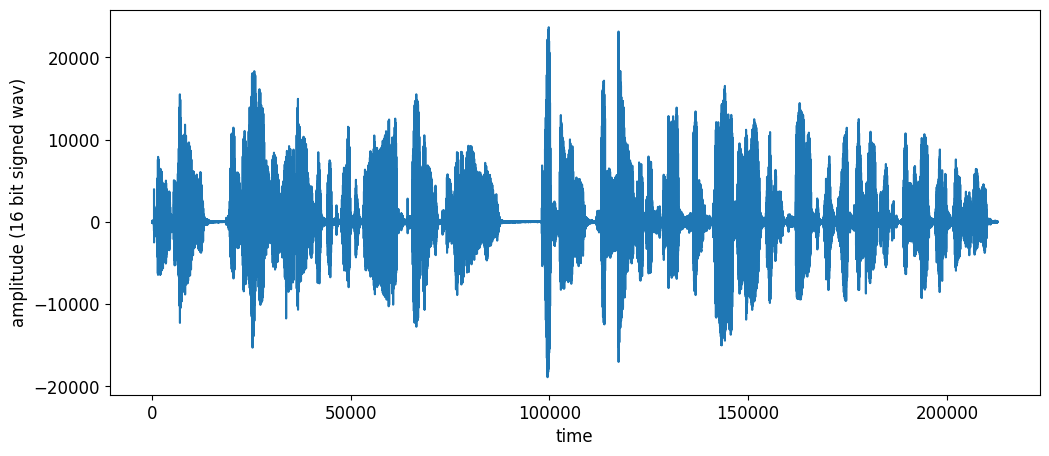

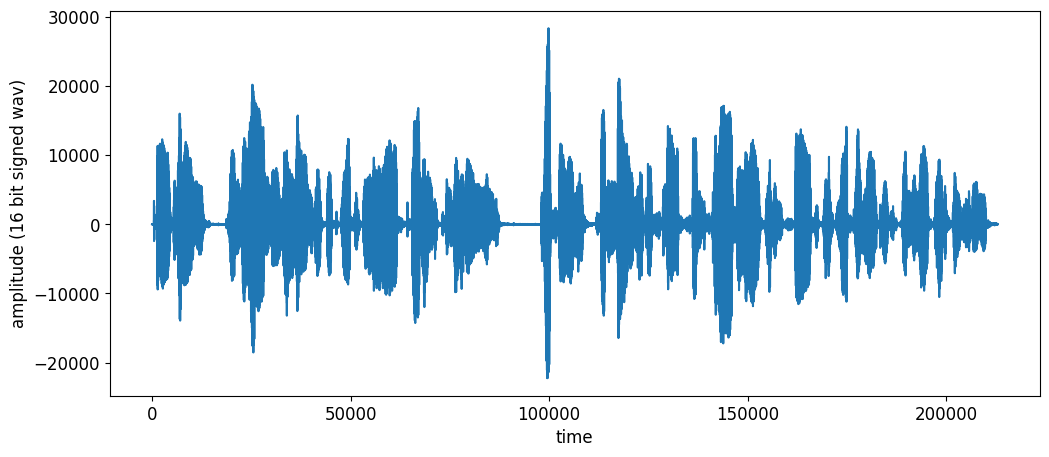

In [28]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(audio)) ,audio)
plt.xlabel("time")
plt.ylabel("amplitude (16 bit signed wav)")
plt.show()
generated_audio_example = real_speech_files[0]
fs, audio = wavfile.read(generated_audio_example)
ipd.Audio(audio, rate=fs)
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(audio)) ,audio)
plt.xlabel("time")
plt.ylabel("amplitude (16 bit signed wav)")
plt.show()

# TIMIT Set Up

In [3]:
# Get resampled real and fake files
data_input_path = '../../data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/'

all_wav_files = pathlib.Path(data_input_path)
all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))

real_resampled_wav_files = [str(file) for file in all_wav_files if 'real' in str(file)]
fake_resampled_wav_files = [str(file) for file in all_wav_files if 'fake_processed' in str(file)]

In [4]:
# Load audio data
real_resampled_audios = [librosa.load(file)[0] for file in real_resampled_wav_files]
fake_resampled_audios = [librosa.load(file)[0] for file in fake_resampled_wav_files]

In [5]:
# Obtain sample rates (assumed same sample rate for all real recordings)
real_sr = [librosa.load(file)[1] for file in real_resampled_wav_files[0:2]][0]
fake_sr = [librosa.load(file)[1] for file in fake_resampled_wav_files[0:2]][0]
print(f'Real sample rate: {real_sr}, fake sample rate: {fake_sr}')

Real sample rate: 22050, fake sample rate: 22050


# Experiment 1: Total Pause Duration

## Manually extracting pauses vs. voiced components

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


USNG THRESHOLD: 0.5%
Audio total duration: 2.321904761904762seconds
0.7091156462585034s silent
1.6127891156462586s voiced
% pause: 30.540255478729637
% voiced: 69.45974452127037
Ratio of pause to voiced for REAL: 0.43968280749114225


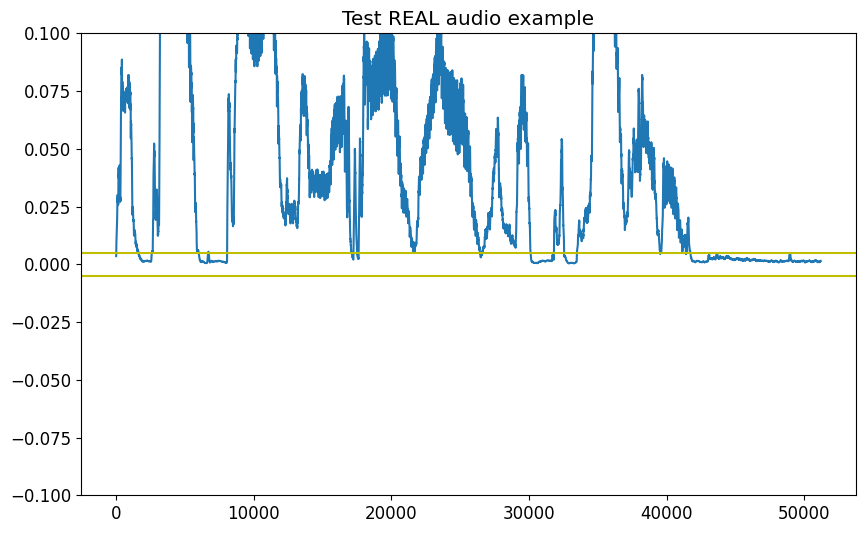

USNG THRESHOLD: 0.5%
Audio total duration: 2.321904761904762seconds
0.2693877551020408s silent
2.052517006802721s voiced
% pause: 11.602015703738427
% voiced: 88.39798429626157
Ratio of pause to voiced for FAKE: 0.131247514251624


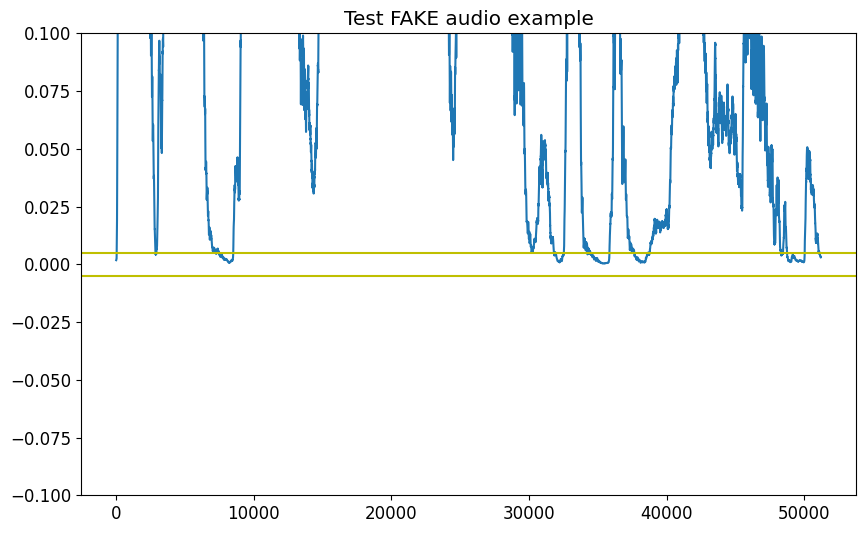

(11.602015703738427, 88.39798429626157, 0.131247514251624)

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_silence(audio, percent, zero_indices=False, label='REAL', plot=True, printout=True):
    #thresh = np.mean(abs(audio))*percent - previous idea - use mean to accoiunt for fake sgenerally being louder?
    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent = np.where(abs(moving_avg) < thresh)
    voiced = np.where(abs(moving_avg) >= thresh)
    
    pct_pause = len(silent[0])*100/(len(silent[0])+len(voiced[0]))
    pct_voiced = len(voiced[0])*100/(len(silent[0])+len(voiced[0]))
    ratio_pause_voiced = len(silent[0])/len(voiced[0]) 
    
    if zero_indices:
        audio[silent] = 0 # Set values below threshold to 0

    if printout:
        print(f'USNG THRESHOLD: {percent*100}%')
        print(f'Audio total duration: {len(moving_avg)/real_sr}seconds')
        print(f'{len(silent[0])/real_sr}s silent')
        print(f'{len(voiced[0])/real_sr}s voiced')

        print(f'% pause: {pct_pause}')
        print(f'% voiced: {pct_voiced}')
        print(f'Ratio of pause to voiced for {label}: {ratio_pause_voiced}')

    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(len(moving_avg)), moving_avg)
        plt.ylim([-0.1, 0.1])
        plt.title(f"Test {label} audio example")

        plt.axhline(y=thresh, color='y')
        plt.axhline(y=-thresh, color='y')

        plt.show()
        
    return pct_pause, pct_voiced, ratio_pause_voiced
    
    
percent = 0.005

phrase = 'SX238'
real_example = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
fake_example = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file][0]


get_silence(librosa.load(real_example)[0], percent, plot=True)
get_silence(librosa.load(fake_example)[0], percent, label='FAKE', plot=True)

In [34]:
# Get rid of folders that contain any wrong files
test_folders = []

for folder in os.listdir(data_input_path):
    phrase_files = [phrase for phrase in real_resampled_wav_files if folder in phrase]
    #phrase_files = [phrase for phrase in real_resampled_wav_files if f'_{folder}.' in phrase]
    #phrase_files = [phrase for phrase in phrase_files if f'/{folder}/' in phrase]
    
    file_names = set([name.split('_')[-1].split('.')[0] for name in phrase_files])
    
    if len(file_names) > 1:
        continue
    
    # Ensure each file has at least 2 real samples
    elif len(phrase_files) > 1:
        test_folders.append(folder)
print(len(test_folders))

149


In [8]:
percent = 0.01

r1s = []
f1s = []

real_files = []
fake_files = []

print(f'Params: {len(test_folders)} different phrases')
    
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_resampled_wav_files)):
    file_name = real_resampled_wav_files[i].split('/')[-1]
    file_dict[file_name] = real_resampled_wav_files[i]

real_resampled_wav_files = [file_dict[item] for item in file_dict.keys()]
    

for n in range(len(test_folders)):
    phrase = test_folders[n]

    real_examples = [file for file in real_resampled_wav_files if f'_{phrase}.' in file]
    real_examples = [file for file in real_resampled_wav_files if f'/{phrase}/' in file]
    
    fake_examples = [file for file in fake_resampled_wav_files if f'_{phrase}.' in file]
    fake_examples = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    if len(real_examples) > len(fake_examples):
        real_examples = random.sample(real_examples, len(fake_examples))
    else:
        fake_examples = random.sample(fake_examples, len(real_examples))
    
    [real_files.append(file) for file in real_examples]
    [fake_files.append(file) for file in fake_examples]

    for item in real_examples:
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s.append(r1)

    for item in fake_examples:
        f1, f2, f3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s.append(f1)
        
print(f'{len(r1s)}, {len(f1s)}')
print(f'{len(real_files)}, {len(fake_files)}')

Params: 149 different phrases
763, 763
763, 763


Ttest_indResult(statistic=35.6396779398094, pvalue=8.839293026850365e-200)



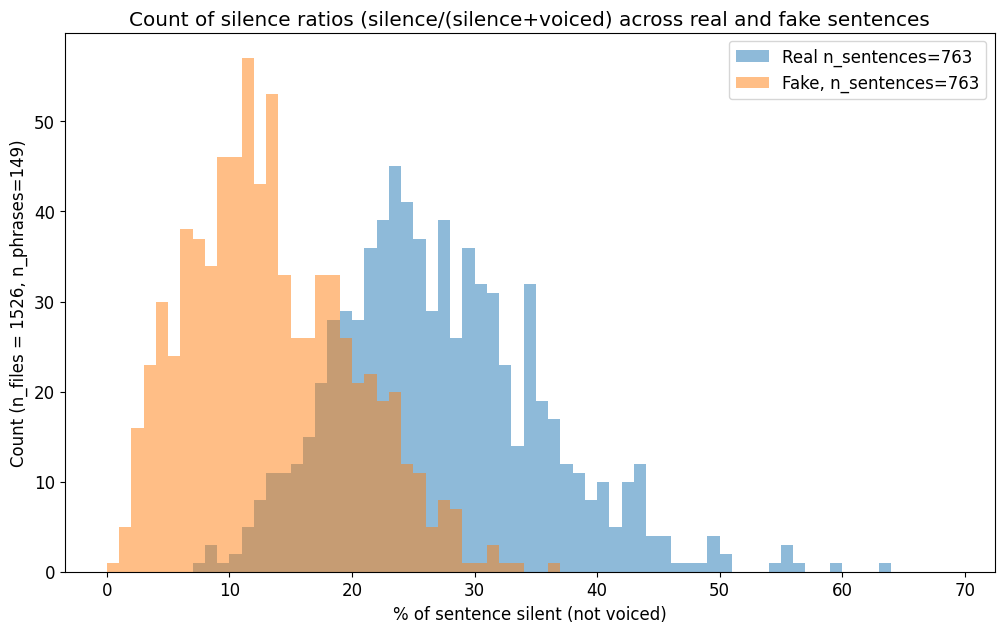

In [9]:
print(stats.ttest_ind(r1s, f1s, equal_var=False))
print()

plt.figure(figsize=(12,7))
plt.hist(r1s, alpha=0.5, label=f'Real n_sentences={len(r1s)}', bins = np.arange(0, 70, 1))
plt.hist(f1s, alpha=0.5, label=f'Fake, n_sentences={len(f1s)}', bins = np.arange(0, 70, 1))
plt.legend(loc='upper right')
plt.xlabel('% of sentence silent (not voiced)')
plt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')
plt.title('Count of silence ratios (silence/(silence+voiced) across real and fake sentences')
plt.show()

# UPDATE: TESTING THE DATA

In [6]:
import sys
import pandas as pd
sys.path.append("/home/ubuntu/MultiModalDeepFake")
from packages.TIMITDataLoader import TIMITDataLoader
timit_data_loader = TIMITDataLoader('/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs')

In [2]:
# Comparing to original
#print(len(set([i.split('/')[-1].split('_')[-1] for i in fake_resampled_wav_files])))
#print(len(set([i.split('/')[-1].split('_')[-1] for i in real_resampled_wav_files])))

In [3]:
#print(len(set([i.split('/')[-1].split('_')[-1] for i in fake_resampled_wav_files])))

In [4]:
original_approach_df = timit_data_loader.generate_split(folder=True)
new_approach_df = timit_data_loader.generate_split()

N real and fake phrases: 500, 500
492 491
/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SI971/real/MWAC0_SI971.WAV
# of Train instances: 589
# of Dev instances: 196
# of Test instances: 198
149
Params: 149 different phrases
# of Train instances: 915
# of Dev instances: 305
# of Test instances: 306


In [15]:
[i for i in original_approach_df['orig_path'] if 'Obama_SX257' in i]

[]

In [13]:
set(new_approach_df['orig_path']) - set(original_approach_df['orig_path']) 

{'/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX257/fake/Obama_SX257.wav',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX92/real/MWCH0_SX92.WAV',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX146/real/MTJM0_SX146.WAV',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX428/real/MDEM0_SX428.WAV',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX349/real/FSBK0_SX349.WAV',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX171/fake/Josh_SX171.wav',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX117/fake/Rachel_SX117.wav',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX382/real/MJLG1_SX382.WAV',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX381/fake/Bella_SX381.wav',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX234/fake/Domi_SX234.wav',
 '/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/SX401/fake/Domi_SX401.wav',
 '/

In [8]:
# Find out how many only have one speaker 
pd.Series([i.split('_')[-1].lower() for i in original_approach_df['path']]).value_counts()

si971.wav     2
si979.wav     2
si2077.wav    2
si516.wav     2
sx366.wav     2
             ..
si2333.wav    2
si706.wav     2
sx353.wav     2
sx117.wav     2
sx17.wav      1
Length: 492, dtype: int64

### END OF UPDATE

# Experiment 2: Distribution of Pauses

USNG THRESHOLD: 1.0%
SPREAD OF SILENCES REAL: 0.011396663139040452
MEAN OF SILENCES REAL: 0.006644953578915843


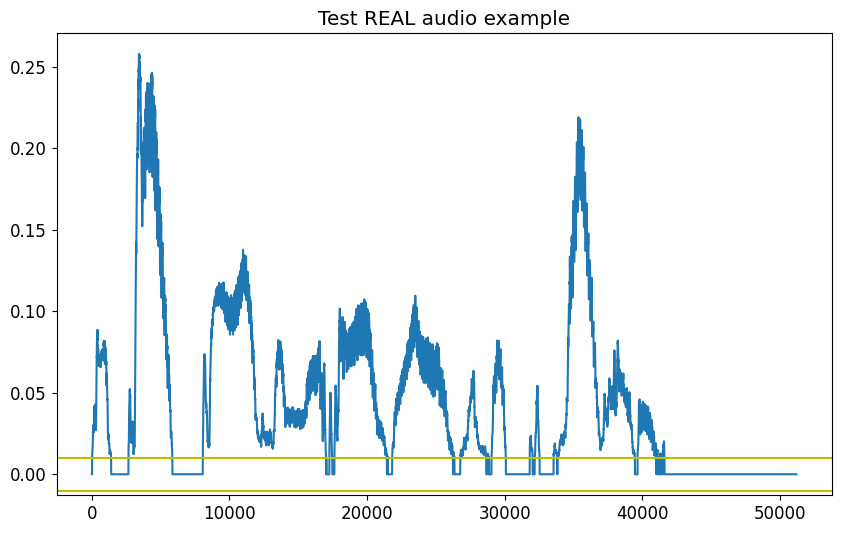

USNG THRESHOLD: 1.0%
SPREAD OF SILENCES FAKE: 0.011305101997525045
MEAN OF SILENCES FAKE: 0.006601820383608735


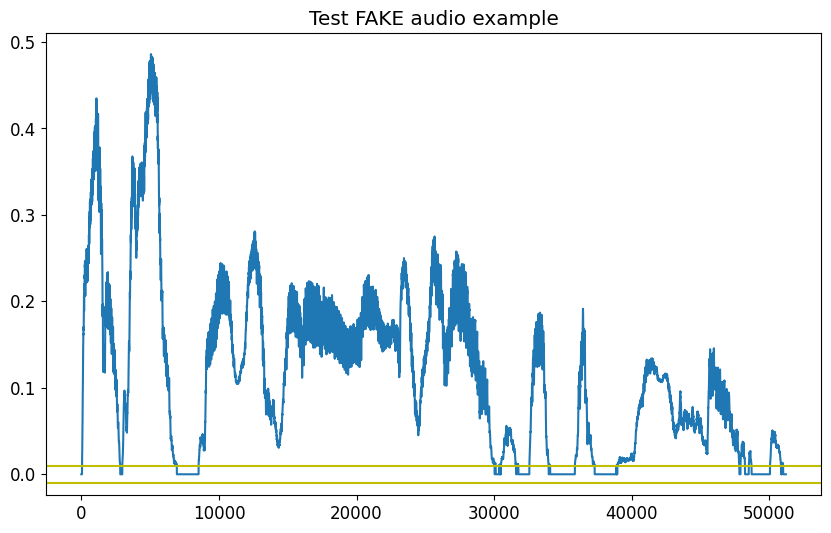

In [36]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_silence_spread(audio, percent, label='REAL', plot=True, printout=True):

    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent_windows = np.where(moving_avg < thresh)
    moving_avg[silent_windows] = 0
    silence_count = 0
    silence_counts = []
    
    for i in range(len(moving_avg)-1):
        item = moving_avg[i]
        next_item = moving_avg[i+1]
        
        if item != 0 and next_item == 0:
            silence_count = 0
            
        elif item == 0 and next_item == 0:
            silence_count += 1
            
        elif item == 0 and next_item != 0:
            silence_counts.append(silence_count)
        
        else:
            continue  
    
    # Get spreads/means and normalise
    spread_of_silences = np.std(silence_counts)/len(moving_avg)
    mean_of_silences = np.mean(silence_counts)/len(moving_avg)
    n_pauses = len(silence_counts)
    

    if printout:
        print(f'USNG THRESHOLD: {percent*100}%')
        print(f'SPREAD OF SILENCES {label}: {spread_of_silences}')
        print(f'MEAN OF SILENCES {label}: {mean_of_silences}')
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(len(moving_avg)), moving_avg)
        #plt.ylim([0, 0.1])
        plt.title(f"Test {label} audio example")

        plt.axhline(y=thresh, color='y')
        plt.axhline(y=-thresh, color='y')

        plt.show()
        
    return spread_of_silences, mean_of_silences, silence_counts, n_pauses
    
    
percent = 0.01

phrase = 'SX238'
real_example = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
fake_example = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file][0]


silence_counts_real, _, _, _ = get_silence_spread(librosa.load(real_example)[0], percent, plot=True)
silence_counts_fake, _, _, _ = get_silence_spread(librosa.load(fake_example)[0], percent, label='FAKE', plot=True)

In [37]:
percent = 0.01

r1s_spread = []
f1s_spread = []
r2s_mean = []
f2s_mean = []
r4s_n_silences = []
f4s_n_silences = []

real_files = []
fake_files = []

print(f'Params: {len(test_folders)} different phrases')
    
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_resampled_wav_files)):
    file_name = real_resampled_wav_files[i].split('/')[-1]
    file_dict[file_name] = real_resampled_wav_files[i]

real_resampled_wav_files = [file_dict[item] for item in file_dict.keys()]
    

for n in range(len(test_folders)):
    phrase = test_folders[n]

    real_examples = [file for file in real_resampled_wav_files if f'_{phrase}.' in file]
    real_examples = [file for file in real_resampled_wav_files if f'/{phrase}/' in file]
    
    fake_examples = [file for file in fake_resampled_wav_files if f'_{phrase}.' in file]
    fake_examples = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    if len(real_examples) > len(fake_examples):
        real_examples = random.sample(real_examples, len(fake_examples))
    else:
        fake_examples = random.sample(fake_examples, len(real_examples))
    
    [real_files.append(file) for file in real_examples]
    [fake_files.append(file) for file in fake_examples]

    for item in real_examples:
        r1, r2, r3, r4 = get_silence_spread(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s_spread.append(r1)
        r2s_mean.append(r2)
        r4s_n_silences.append(r4)

    for item in fake_examples:
        f1, f2, f3, f4 = get_silence_spread(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s_spread.append(f1)
        f2s_mean.append(f2)
        f4s_n_silences.append(f4)
        
print(f'{len(r1s)}, {len(f1s)}')
print(f'{len(real_files)}, {len(fake_files)}')

Params: 149 different phrases
763, 763
763, 763


Ttest_indResult(statistic=8.164515412414378, pvalue=6.694137128166599e-16)



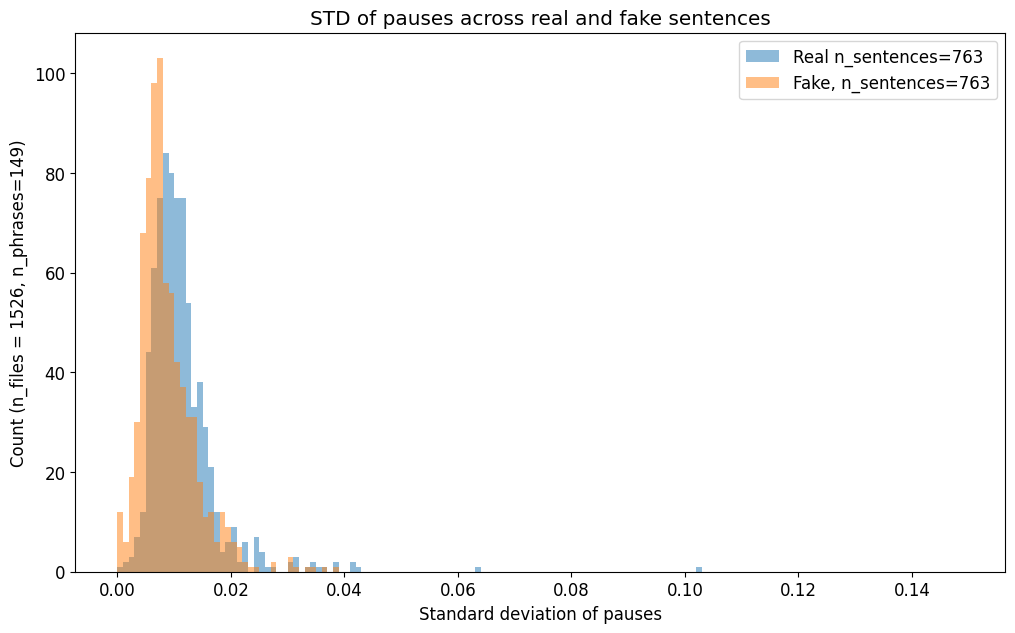

In [38]:
print(stats.ttest_ind(r1s_spread, f1s_spread))
print()

plt.figure(figsize=(12,7))
plt.hist(r1s_spread, alpha=0.5, label=f'Real n_sentences={len(r1s_spread)}', bins = np.arange(0, 0.15, 0.001))
plt.hist(f1s_spread, alpha=0.5, label=f'Fake, n_sentences={len(f1s_spread)}', bins = np.arange(0, 0.15, 0.001))
plt.legend(loc='upper right')
plt.xlabel('Standard deviation of pauses')
plt.ylabel(f'Count (n_files = {len(r1s_spread)+len(f1s_spread)}, n_phrases={len(test_folders)})')
plt.title('STD of pauses across real and fake sentences')
plt.show()

Ttest_indResult(statistic=5.258946295231168, pvalue=1.6546646804796487e-07)



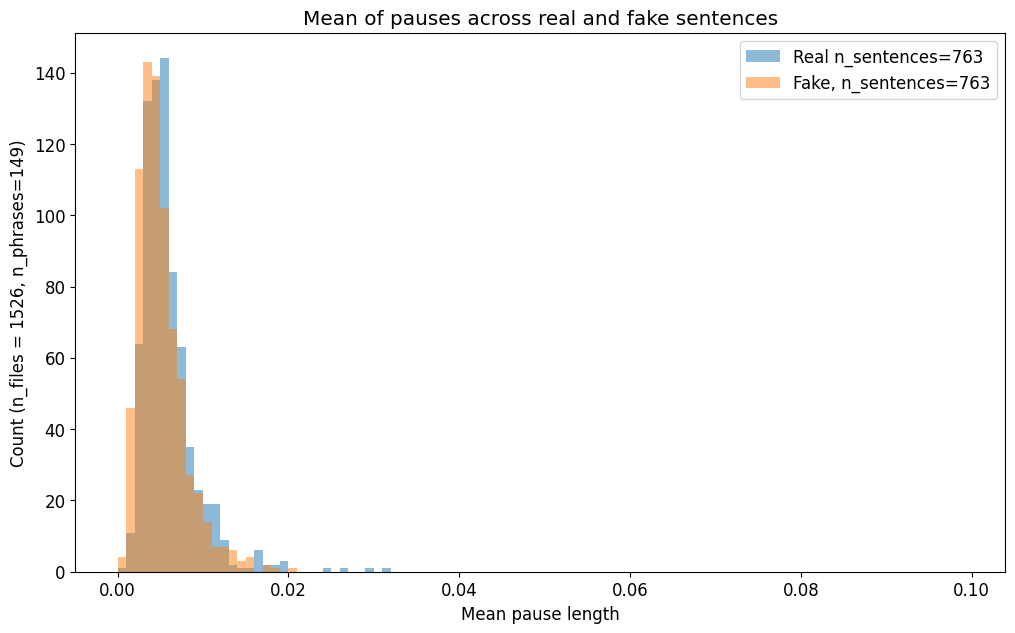

In [39]:
print(stats.ttest_ind(r2s_mean, f2s_mean))
print()

plt.figure(figsize=(12,7))
plt.hist(r2s_mean, alpha=0.5, label=f'Real n_sentences={len(r2s_mean)}', bins = np.arange(0, 0.1, 0.001))
plt.hist(f2s_mean, alpha=0.5, label=f'Fake, n_sentences={len(f2s_mean)}', bins = np.arange(0, 0.1, 0.001))
plt.legend(loc='upper right')
plt.xlabel('Mean pause length')
plt.ylabel(f'Count (n_files = {len(r2s_mean)+len(f2s_mean)}, n_phrases={len(test_folders)})')
plt.title('Mean of pauses across real and fake sentences')
plt.show()

# Experiment 3: Number of Pauses

Ttest_indResult(statistic=22.64499462867, pvalue=4.222755964045693e-98)



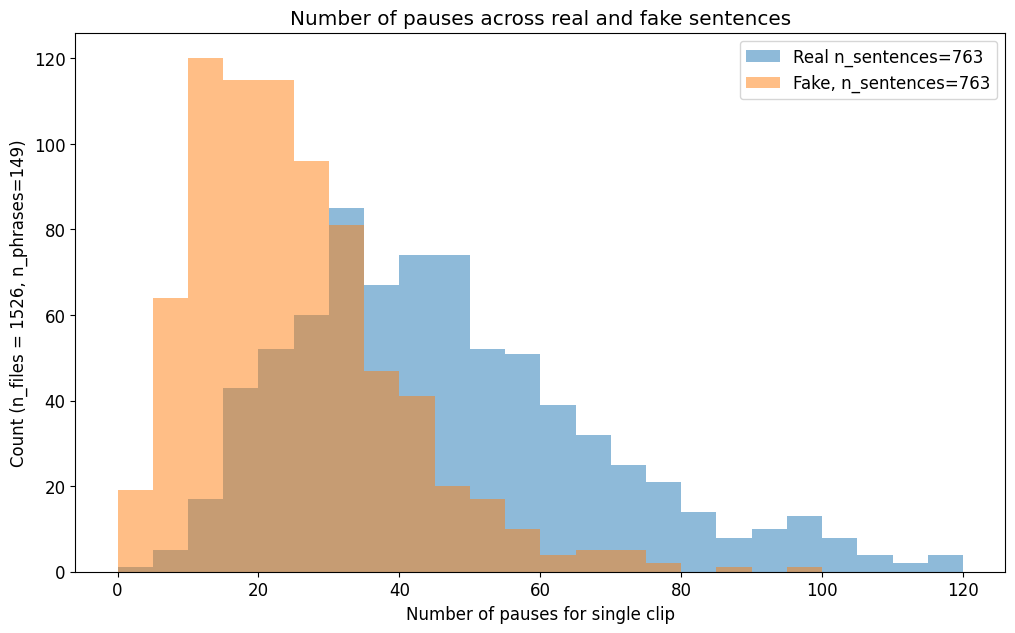

In [40]:
print(stats.ttest_ind(r4s_n_silences, f4s_n_silences))
print()

plt.figure(figsize=(12,7))
plt.hist(r4s_n_silences, alpha=0.5, label=f'Real n_sentences={len(r4s_n_silences)}', bins = np.arange(0, 125, 5))
plt.hist(f4s_n_silences, alpha=0.5, label=f'Fake, n_sentences={len(f4s_n_silences)}', bins = np.arange(0, 125, 5))
plt.legend(loc='upper right')
plt.xlabel('Number of pauses for single clip')
plt.ylabel(f'Count (n_files = {len(r2s_mean)+len(f2s_mean)}, n_phrases={len(test_folders)})')
plt.title('Number of pauses across real and fake sentences')
plt.show()

Ttest_indResult(statistic=22.64499462867, pvalue=4.222755964045693e-98)



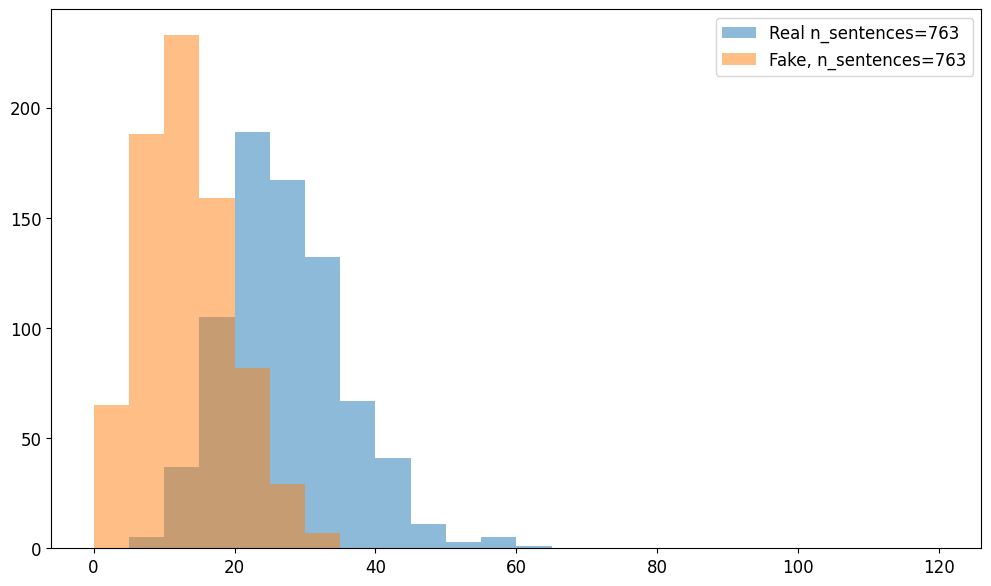

In [41]:
print(stats.ttest_ind(r4s_n_silences, f4s_n_silences))
print()

plt.figure(figsize=(12,7))
plt.hist(r1s, alpha=0.5, label=f'Real n_sentences={len(r1s)}', bins = np.arange(0, 125, 5))
plt.hist(f1s, alpha=0.5, label=f'Fake, n_sentences={len(f1s)}', bins = np.arange(0, 125, 5))
plt.legend(loc='upper right')

plt.show()

# Experiment 4: Amplitude Modelling (derivative)

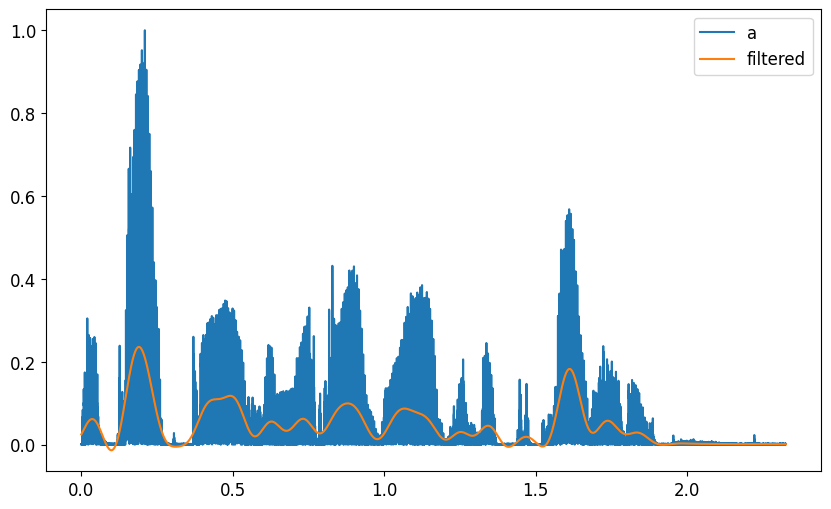

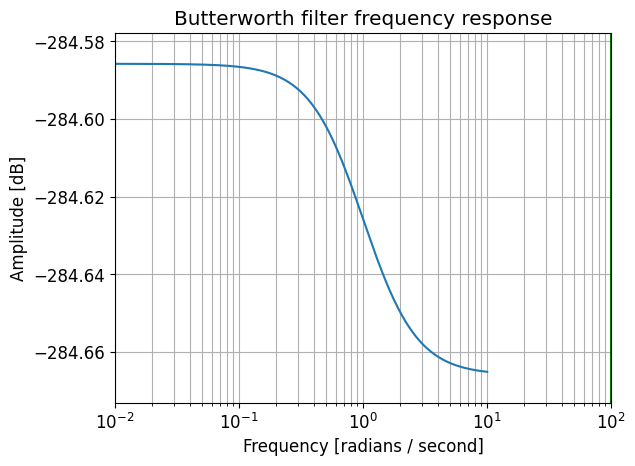

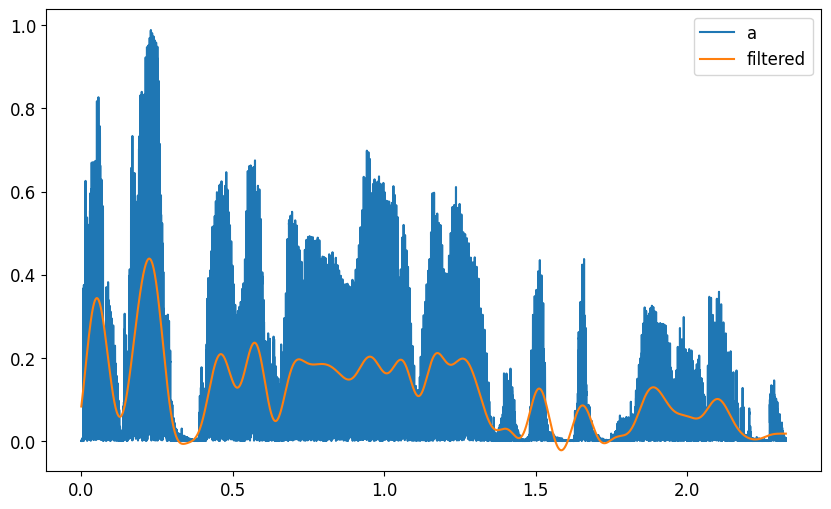

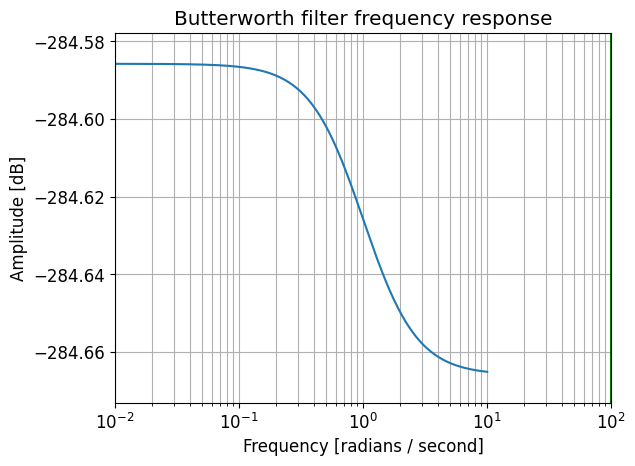

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

phrase = 'SX238'
real_example = abs(librosa.load([file for file in real_resampled_wav_files if f'/{phrase}/' in file][0])[0])
fake_example = abs(librosa.load([file for file in fake_resampled_wav_files if f'/{phrase}/' in file][0])[0])

fs = real_sr  # Sampling frequency
# Generate the time vector properly
t = np.arange(len(real_example)) / fs
signala = real_example # with frequency of 100
plt.figure(figsize=(10,6))
plt.plot(t, signala, label='a')


fc = 10  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, signala)
plt.plot(t, output, label='filtered')
plt.legend()
plt.show()

w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()


fs = real_sr  # Sampling frequency
# Generate the time vector properly
t = np.arange(len(fake_example)) / fs
signala = fake_example # with frequency of 100
plt.figure(figsize=(10,6))
plt.plot(t, signala, label='a')


fc = 10  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, signala)
plt.plot(t, output, label='filtered')
plt.legend()
plt.show()

w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

USNG CUTOFF FREQUENCY: 10
Average derivative of amplitude: -4.6493621158625257e-07
Mean amplitude: 0.045125821470183416


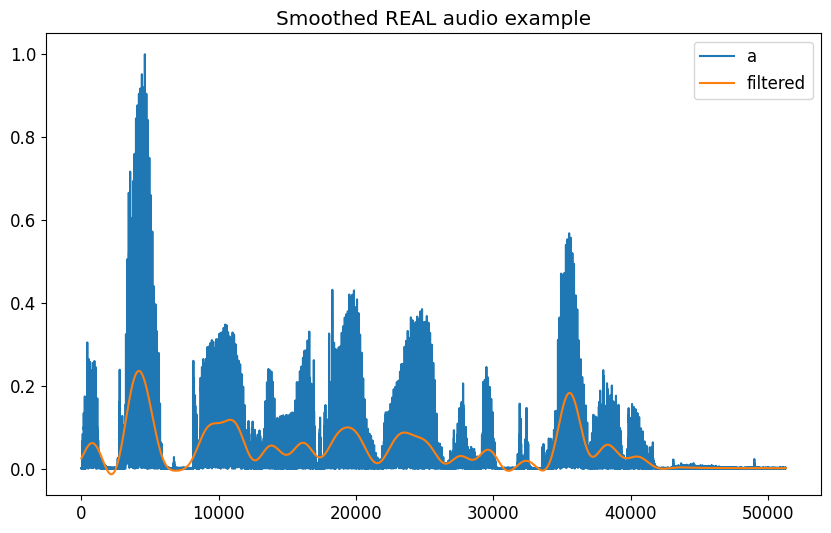

USNG CUTOFF FREQUENCY: 10
Average derivative of amplitude: -1.2714888945833878e-06
Mean amplitude: 0.11788671064261053


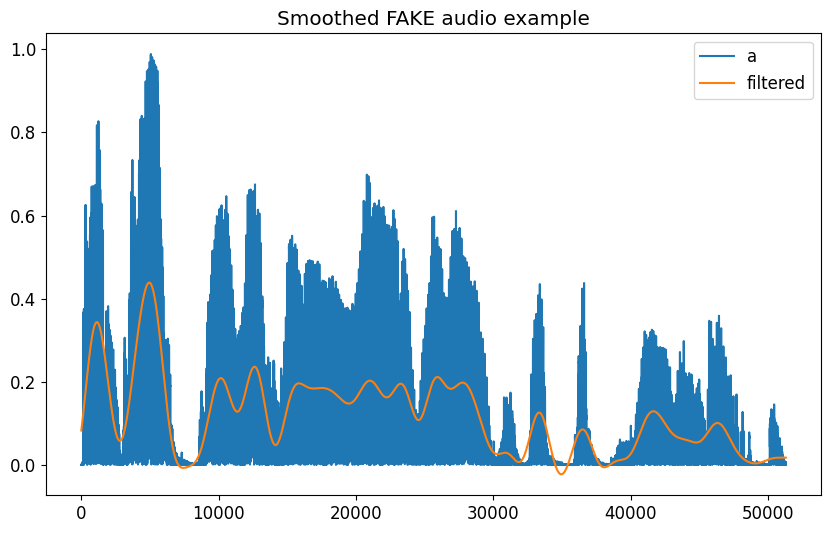

(1.2714888945833878e-06, 0.11788671064261053)

In [43]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from numpy import diff

def filter_signal(audio, sample_rate, cutoff_frequency):
    t = np.arange(len(audio)) / sample_rate 
    w = cutoff_frequency / (sample_rate / 2) 
    b, a = signal.butter(5, w, 'low')
    smoothed_signal = signal.filtfilt(b, a, audio)
    
    return smoothed_signal
    

def get_amplitude(audio, sample_rate=real_sr, cutoff_frequency=10, zero_indices=False, label='REAL', plot=True, printout=True):
    #thresh = np.mean(abs(audio))*percent - previous idea - use mean to accoiunt for fake sgenerally being louder?
    
    abs_audio = abs(audio)
    smoothed_signal = filter_signal(abs_audio, sample_rate, cutoff_frequency)
    
    deriv_amplitude = np.mean(diff(smoothed_signal))
    mean_amplitude = np.mean(smoothed_signal)
    
    
    if printout:
        print(f'USNG CUTOFF FREQUENCY: {cutoff_frequency}')
        print(f'Average derivative of amplitude: {deriv_amplitude}')
        print(f'Mean amplitude: {mean_amplitude}')

    
    if plot:
        plt.figure(figsize=(10,6))
        plt.title(f"Smoothed {label} audio example")
        plt.plot(range(len(abs_audio)), abs_audio, label='a')

        plt.plot(range(len(smoothed_signal)), smoothed_signal, label='filtered')
        plt.legend()

        plt.show()
        
    return abs(deriv_amplitude), mean_amplitude
    
    
percent = 0.005

phrase = 'SX238'
real_example = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
fake_example = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file][0]


get_amplitude(librosa.load(real_example)[0], plot=True)
get_amplitude(librosa.load(fake_example)[0], label='FAKE', plot=True)

In [44]:
percent = 0.01

r1s_deriv = []
f1s_deriv = []
amp_r2s_mean = []
amp_f2s_mean = []

real_files = []
fake_files = []

print(f'Params: {len(test_folders)} different phrases')
    
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_resampled_wav_files)):
    file_name = real_resampled_wav_files[i].split('/')[-1]
    file_dict[file_name] = real_resampled_wav_files[i]

real_resampled_wav_files = [file_dict[item] for item in file_dict.keys()]
    

for n in range(len(test_folders)):
    phrase = test_folders[n]

    real_examples = [file for file in real_resampled_wav_files if f'_{phrase}.' in file]
    real_examples = [file for file in real_resampled_wav_files if f'/{phrase}/' in file]
    
    fake_examples = [file for file in fake_resampled_wav_files if f'_{phrase}.' in file]
    fake_examples = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    if len(real_examples) > len(fake_examples):
        real_examples = random.sample(real_examples, len(fake_examples))
    else:
        fake_examples = random.sample(fake_examples, len(real_examples))
    
    [real_files.append(file) for file in real_examples]
    [fake_files.append(file) for file in fake_examples]

    for item in real_examples:
        r1, r2 = get_amplitude(librosa.load(item)[0], plot=False, printout=False)
        r1s_deriv.append(r1)
        amp_r2s_mean.append(r2)

    for item in fake_examples:
        f1, f2 = get_amplitude(librosa.load(item)[0], plot=False, printout=False)
        f1s_deriv.append(f1)
        amp_f2s_mean.append(f2)
        
print(f'{len(r1s_deriv)}, {len(f1s_deriv)}')
print(f'{len(real_files)}, {len(fake_files)}')

Params: 149 different phrases
763, 763
763, 763


https://dacg.in/2018/11/17/statistical-test-cheat-sheet/

Ttest_indResult(statistic=-11.991831915665808, pvalue=3.3879393429348107e-31)
Real mean and std: 1.5683806552278703e-07, 1.9836697569131204e-07
Fake mean and std: 3.6000481113600456e-07, 4.2352198741137513e-07

MannwhitneyuResult(statistic=200913.0, pvalue=1.1084558184552504e-25)


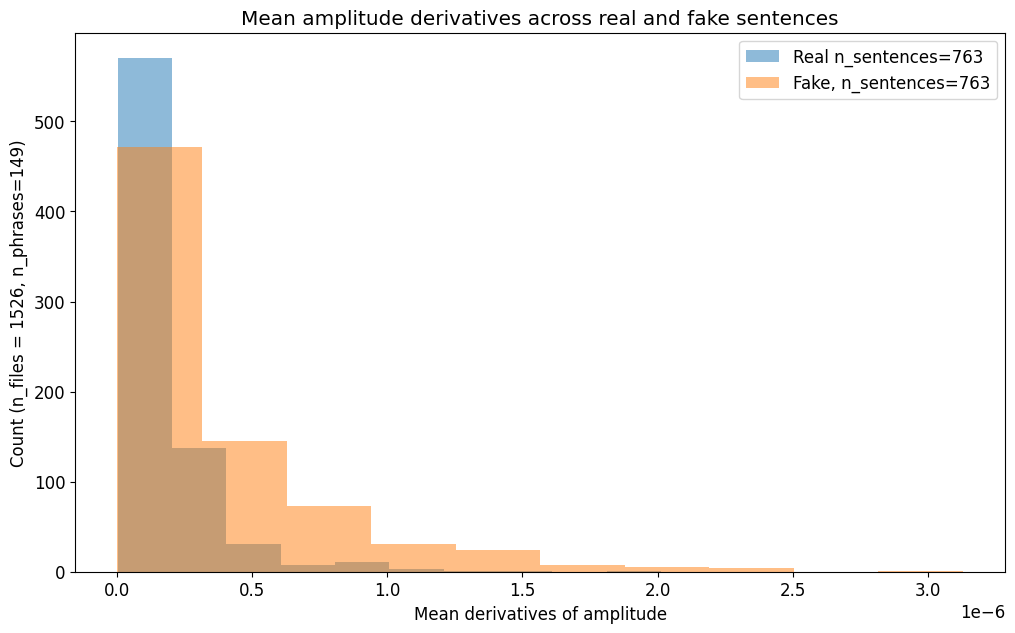

In [48]:
print(stats.ttest_ind(r1s_deriv, f1s_deriv, equal_var=False))
print(f'Real mean and std: {np.mean(r1s_deriv)}, {np.std(r1s_deriv)}')
print(f'Fake mean and std: {np.mean(f1s_deriv)}, {np.std(f1s_deriv)}')
print()

print(stats.mannwhitneyu(r1s_deriv, f1s_deriv))

plt.figure(figsize=(12,7))
plt.hist(r1s_deriv, alpha=0.5, label=f'Real n_sentences={len(r1s_deriv)}')#, bins = np.arange(0, 125, 5))
plt.hist(f1s_deriv, alpha=0.5, label=f'Fake, n_sentences={len(f1s_deriv)}')#, bins = np.arange(0, 125, 5))
plt.legend(loc='upper right')
plt.xlabel('Mean derivatives of amplitude')
plt.ylabel(f'Count (n_files = {len(r1s_deriv)+len(f1s_deriv)}, n_phrases={len(test_folders)})')
plt.title('Mean amplitude derivatives across real and fake sentences')
plt.show()

# Experiment 6: Mean Amplitude

Ttest_indResult(statistic=4.940571753427949, pvalue=8.647672136730852e-07)



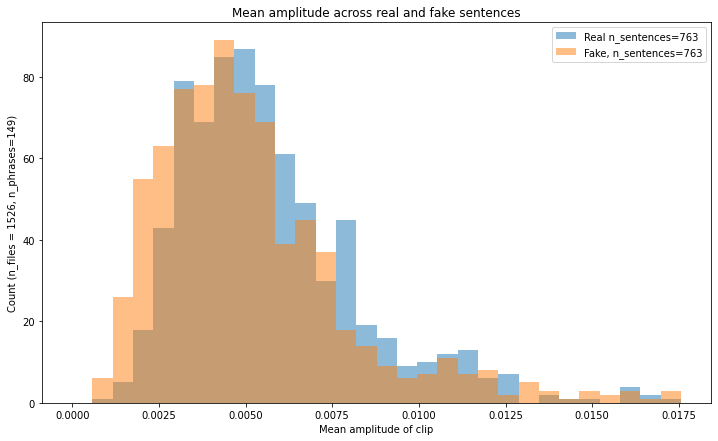

In [24]:
print(stats.ttest_ind(r2s_mean, f2s_mean))
print()

plt.figure(figsize=(12,7))
plt.hist(r2s_mean, alpha=0.5, label=f'Real n_sentences={len(r2s_mean)}', bins = np.arange(0, max(f2s_mean), max(f2s_mean)/30))
plt.hist(f2s_mean, alpha=0.5, label=f'Fake, n_sentences={len(f2s_mean)}', bins = np.arange(0, max(f2s_mean), max(f2s_mean)/30))
plt.legend(loc='upper right')
plt.xlabel('Mean amplitude of clip')
plt.ylabel(f'Count (n_files = {len(r2s_mean)+len(f2s_mean)}, n_phrases={len(test_folders)})')
plt.title('Mean amplitude across real and fake sentences')
plt.show()

# Experiment 7: Logistic Regression

In [39]:
labels = [1 if 'fake_processed' in file else 0 for file in real_files+fake_files]
features = pd.DataFrame({'file': real_files+fake_files, 'pause_ratio':r1s+f1s, 'pause_mean':r2s_mean+f2s_mean, 'pause_std':r1s_spread+f1s_spread, 'n_pauses':r4s_n_silences+f4s_n_silences, 'amp_deriv':r1s_deriv+f1s_deriv, 'amp_mean':amp_r2s_mean+amp_f2s_mean, 'fake':labels})
features.tail()

,file,pause_ratio,pause_mean,pause_std,n_pauses,amp_deriv,amp_mean,fake
1521,../../data/TIMIT_and_ElevenLabs/TIMIT and Elev...,14.324856,0.003067,0.006154,20,2.870352e-07,0.108800,1
1522,../../data/TIMIT_and_ElevenLabs/TIMIT and Elev...,12.120719,0.005481,0.008143,20,1.651349e-07,0.046790,1
1523,../../data/TIMIT_and_ElevenLabs/TIMIT and Elev...,6.745337,0.004358,0.007630,35,3.550619e-08,0.101683,1
1524,../../data/TIMIT_and_ElevenLabs/TIMIT and Elev...,12.903357,0.005314,0.009096,26,1.487838e-08,0.105013,1
1525,../../data/TIMIT_and_ElevenLabs/TIMIT and Elev...,10.350627,0.004554,0.006386,24,3.866094e-08,0.096479,1


In [40]:
# Prepare data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(features.iloc[:, 1:-1], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

0.9031413612565445
Feature: 0, Score: -5.51587
Feature: 1, Score: -2.45999
Feature: 2, Score: -1.04060
Feature: 3, Score: -3.46569
Feature: 4, Score: 1.37089
Feature: 5, Score: 7.34695


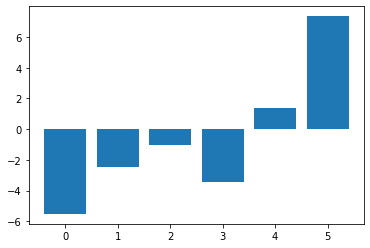

In [41]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

importance = clf.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Pause ratio only

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features[['pause_ratio']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.8272251308900523


## N Pauses only

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features[['n_pauses']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.7356020942408377


## Amplitude only

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features[['amp_mean']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.8664921465968587


# Experiment 8: SVC

In [49]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features.iloc[:, 1:-1], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = svm.SVC()
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.9109947643979057

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

print(grid.best_params_)
  
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.511 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.511 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.511 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.509 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.799 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.830 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.755 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.856 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [51]:
clf = svm.SVC(C=1000, kernel='rbf')
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.9267015706806283

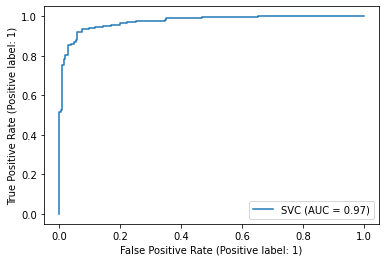

0.9222222222222223

In [52]:
from sklearn.metrics import RocCurveDisplay, f1_score

RocCurveDisplay.from_estimator(clf, X_test_norm, y_test)
plt.show()

y_pred = clf.predict(X_test_norm)
f1_score(y_test, y_pred)

# Shibb Experiment 1: Pause sentences

## Which phrases are causing the most separation?

In [30]:
'''
# SYnch test - make sure all files are aligned within the lists
# Also temporary file-error handling for mis-read files
n_passed = 0
passed_indices = []

for i in range(len(real_files)):
    if real_files[i].split('/')[-1].split('_')[1].split('.')[0] != fake_files[i].split('/')[-1].split('_')[1].split('.')[0]:
        print(f"Failed at index {i} for phrase {real_files[i].split('/')[-1].split('_')[1].split('.')[0]}")
    else:
        n_passed = n_passed + 1
        passed_indices.append(i)
        
print(f'{n_passed} passed out of total {len(real_files)}')

print(f'Previous len real files: {len(real_files)}')
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_files)):
    file_name = real_files[i].split('/')[-1]
    file_dict[file_name] = real_files[i]
    
fake_file_dict = {}
for i in range(len(fake_files)):
    file_name = real_files[i].split('/')[-1]
    fake_file_dict[file_name] = fake_files[i]

real_files = [file_dict[item] for item in file_dict.keys()]
print(f'New len real files: {len(real_files)}')
fake_files = [fake_file_dict[item] for item in file_dict.keys()]
print(f'New len fake files: {len(fake_files)}')
'''

'\n# SYnch test - make sure all files are aligned within the lists\n# Also temporary file-error handling for mis-read files\nn_passed = 0\npassed_indices = []\n\nfor i in range(len(real_files)):\n    if real_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0] != fake_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0]:\n        print(f"Failed at index {i} for phrase {real_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0]}")\n    else:\n        n_passed = n_passed + 1\n        passed_indices.append(i)\n        \nprint(f\'{n_passed} passed out of total {len(real_files)}\')\n\nprint(f\'Previous len real files: {len(real_files)}\')\n# Temporary: remove duplicate files\nfile_dict = {}\nfor i in range(len(real_files)):\n    file_name = real_files[i].split(\'/\')[-1]\n    file_dict[file_name] = real_files[i]\n    \nfake_file_dict = {}\nfor i in range(len(fake_files)):\n    file_name = real_files[i].split(\'/\')[-1]\n    fake_file_dict[file_name] = fake_files[i]\n\nreal_fil

In [31]:
'''
# Check alignment
for i in [0, 10, 100, 50, 98]:
    print(real_files[i])
    print(fake_files[i])
'''

'\n# Check alignment\nfor i in [0, 10, 100, 50, 98]:\n    print(real_files[i])\n    print(fake_files[i])\n'

In [32]:
agg_r1s = []
agg_f1s = []

for folder in test_folders:
    real_files_folder = [os.path.join(data_input_path, folder, 'real', file) for file in os.listdir(os.path.join(data_input_path, folder, 'real'))]
    fake_files_folder = [os.path.join(data_input_path, folder, 'fake', file) for file in os.listdir(os.path.join(data_input_path, folder, 'fake'))]
    
    r1s_phrases = []
    f1s_phrases = []
    
    for i in range(len(real_files_folder)):
        item = real_files_folder[i]
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s_phrases.append(r1)

        item = fake_files_folder[i]
        f1, f2, f3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s_phrases.append(f1)
    
    agg_r1s.append(r1s_phrases)
    agg_f1s.append(f1s_phrases)
    
print(len(agg_r1s))
print(len(agg_f1s))

print(len(agg_r1s[10]))
print(len(agg_f1s[10]))

149
149
7
7


Investigate the top deltas:

In [33]:
avg_agg_r1s = [np.mean(item) for item in agg_r1s]
avg_agg_f1s = [np.mean(item) for item in agg_f1s]

df = pd.DataFrame({'phrase': test_folders, 'AVG_real_pct_pause': avg_agg_r1s, 'AVG_fake_pct_pause': avg_agg_f1s})
df['delta'] = df['AVG_fake_pct_pause'] - df['AVG_real_pct_pause']
df['abs_delta'] = abs(df['delta'])
df = df.sort_values('abs_delta', ascending=False)
print(df.head())

print()
print(f'Phrases: ')
print(f'{df.iloc[0,0]}: ducks have webbed feet and colorful feathers')
print(f'{df.iloc[1,0]}: bagpipes and bongos are musical instruments')
print(f'{df.iloc[2,0]}: irish youngsters eat fresh kippers for breakfast')
print(f'{df.iloc[3,0]}: smash lightbulbs and their cash value will diminish to nothing')
print(f'{df.iloc[4,0]}: shell shock caused by shrapnel is sometimes cured through group therapy')

    phrase  AVG_real_pct_pause  AVG_fake_pct_pause      delta  abs_delta
96   SX261           10.197580           23.285873  13.088293  13.088293
21   SX414           28.595722           18.114631 -10.481091  10.481091
19   SX438           25.430616           15.491227  -9.939389   9.939389
130  SX127           13.572795           22.915434   9.342639   9.342639
62   SX307           12.763713           22.032793   9.269081   9.269081

Phrases: 
SX261: ducks have webbed feet and colorful feathers
SX414: bagpipes and bongos are musical instruments
SX438: irish youngsters eat fresh kippers for breakfast
SX127: smash lightbulbs and their cash value will diminish to nothing
SX307: shell shock caused by shrapnel is sometimes cured through group therapy


<font color='red'>

# Next:
    
* sliding window of where the pause is the greatest within each sentence
* <b>distribution</b> of silences, not just ratio of silence to voiced 
* biden vs fake biden, obama vs fake obama
* biden vs obama
* autoencoder question
    
One data eng pipeline/dataset 
Youtube upload 
Test mine on all librispeech fakes and see how it transfers - train a one feature classifier 
Test mine on biden and obama 

    
# Other Cadence Ideas
* words per minute
* average speaking rate
* ratio of pauses 

### Shibb ideas:
1. Lung capacity - if we can even just record when you’re likely to take a breath, that might give us a cue into whether its you or not. I put some long phrases into eleven labs to try this and it worked well.
2. Long, and repetitive phrases - when you give eleven labs repetitive phrases, it sounds exactly the same each time. Also, with long phrases, it starts to sound super robotic. Example attached

![SNOWFALL](table.png)

In [34]:
[file for file in real_files if 'SX340' in file]

[]

In [35]:
#fig, ax = plt.subplots()
#ax.plot(x, y)
#ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

SyntaxError: invalid syntax (<ipython-input-35-a31e59b3f0e8>, line 7)

In [ ]:
'''
folder = 'SX340'
[os.path.join(data_input_path, folder, 'real', file) for file in os.listdir(os.path.join(data_input_path, folder, 'real'))]
'''

### Check: are results for different aggregation methods consistent?
> Yes

Explore results:

In [ ]:
sum_agg_r1s = [sum(item) for item in agg_r1s]
sum_agg_f1s = [sum(item) for item in agg_f1s]

df = pd.DataFrame({'phrase': test_folders, 'SUM_real_pct_pause': sum_agg_r1s, 'SUM_fake_pct_pause': sum_agg_f1s})
df['delta'] = df['SUM_fake_pct_pause'] - df['SUM_real_pct_pause']
df['abs_delta'] = abs(df['delta'])
df = df.sort_values('abs_delta', ascending=False)
df.head()

## Disvoice Prosody Features

# Failed Experiments

In [ ]:
test_file = real_resampled_wav_files[0]
test_audio = librosa.load(test_file)[0]

#print(min(abs(test_audio)))

#test_audio[0:10000] = 0.0

#test_audio[13000:14000] = 0.0

sf.write('temp_audio.wav', test_audio, real_sr)

f = prosodyf.extract_features_file('temp_audio.wav', static=True, plots=False, fmt="csv")

print(f.T[92:103])

os.remove('temp_audio.wav')


In [ ]:
max(np.array([features[i].loc['maxdurpause'] for i in range(len(features))]))

## PyDub Silence Detector

In [ ]:
from pydub import AudioSegment, silence
#audio = real_resampled_audios[0]
#audio = librosa.amplitude_to_db(audio)
aud = AudioSegment.from_wav(real_resampled_wav_files[0])
print(silence.detect_silence(aud, min_silence_len=10, silence_thresh=16))

In [ ]:
sf.write('temp_audio.wav', audio, real_sr)

aud = AudioSegment.from_wav('temp_audio.wav')
print(silence.detect_silence(aud, min_silence_len=10, silence_thresh=0))

os.remove('temp_audio.wav')